# Convergence Analysis

## Table of Contents
* [1) Checking Approximation for Increasing Number of Knot Points](#first-bullet)
* [2) Dynamic Chebyshev Convergence](#second-bullet)
    - [2a) Reference Algorithm](#seconda-bullet)
    - [2b) Varying Number of Nodal Points](#secondb-bullet)
    - [2c) Varying Number of Sample Paths](#secondc-bullet)
    - [2d) Convergence Plot](#secondd-bullet)

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import scipy.sparse
import scipy.sparse.linalg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
from DC import DynamicChebyshev
from LSM import MonteCarloOptionPricing
from FD import AmericanPutFiniteDifference

# 1) Checking Approximation for Increasing Number of Knot Points <a class="anchor" id="first-bullet"></a>

In [2]:
# Placeholder price list
price = []

# Loop for the MonteCarloOptionPricing
for S0 in np.arange(55, 170, 0.5):
    mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=S0, K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=252, seed=15_001)
    simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
    mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')
    price.append(mc_option_pricing.C.mean())

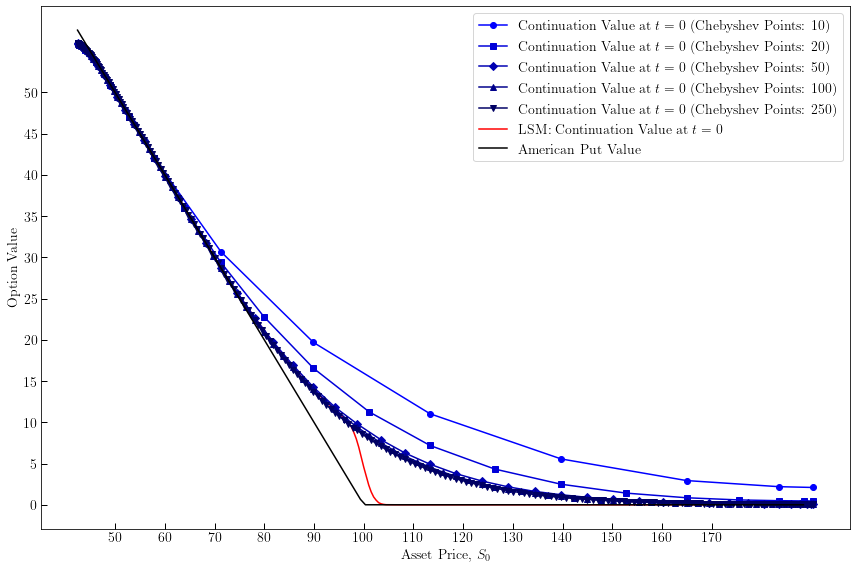

In [4]:
# Define the array of number of Chebyshev points to loop over
chebyshev_points_array = [10, 20, 50, 100, 250] 

# Initialize the figure for plotting
plt.figure(figsize=(12, 8))

# Generate shades of blue
# Darker shades for more Chebyshev points
num_points = len(chebyshev_points_array)
blue_shades = ["#%02x%02x%02x" % (0, 0, 255 - int(155 * i/(num_points - 1))) for i in range(num_points)]

markers = ['o', 's', 'D', '^', 'v', '>', '<']


# Add the MonteCarloOptionPricing results to the plot
plt.plot(np.arange(55, 170, 0.5), price, linestyle='-', color='r', label='LSM: Continuation Value at $t=0$')

# Loop over the array of Chebyshev points
for idx, n_chebyshev_pol in enumerate(chebyshev_points_array):
    # Initialize the DynamicChebyshev object with the current number of Chebyshev points
    DC_option_pricing = DynamicChebyshev(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=32, 
                                      n_chebyshev_pol=n_chebyshev_pol, seed=150_000)

    # offline phase
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

    # online phase
    DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)

    # Plot the continuation value at t=0 for each number of Chebyshev points
    plt.plot(np.exp(xknots), DC_option_pricing.C[:,0], linestyle='-', color=blue_shades[idx], marker=markers[idx % len(markers)], label=f'Continuation Value at $t=0$ (Chebyshev Points: {n_chebyshev_pol})')

# Plot the intrinsic value 
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
put_value = np.maximum(DC_option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, put_value, '-k', label='American Put Value')  # 'k' for black color

# Adding labels and title
plt.xlabel('Asset Price, $S_0$', fontsize=14)
plt.ylabel('Option Value', fontsize=14)
#plt.title('Dynamic Chebyshev Method - Computed using MC for Different Chebyshev Points', fontsize=16)

# After all plotting commands (but before plt.show or plt.savefig):
handles, labels = plt.gca().get_legend_handles_labels()

# Manually define the order of your labels, for example:
desired_order = ['Continuation Value at $t=0$ (Chebyshev Points: 10)', 'Continuation Value at $t=0$ (Chebyshev Points: 20)', 'Continuation Value at $t=0$ (Chebyshev Points: 50)', 'Continuation Value at $t=0$ (Chebyshev Points: 100)', 'Continuation Value at $t=0$ (Chebyshev Points: 250)', 'LSM: Continuation Value at $t=0$','American Put Value']

# Create a dictionary to map the current labels to their handles
label_handle_map = dict(zip(labels, handles))

# Reorder handles using the desired order
ordered_handles = [label_handle_map[label] for label in desired_order if label in label_handle_map]

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, desired_order, fontsize=14)

plt.xticks(np.arange(50, 180, 10))
plt.yticks(np.arange(0, 55, 5))

# Customize tick marks
plt.tick_params(axis='both',          
                direction='in',       
                length=6,             
                width=1,              
                colors='black',       
                grid_alpha=0.5,       
               labelsize=14)       

plt.tight_layout()

if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")
    
plt.savefig("../Results/plots/DC_approximation.pdf", bbox_inches='tight')

# Dynamic Chebyshev Convergence <a class="anchor" id="second-bullet"></a>

## 2a) Reference Algorithm <a class="anchor" id="seconda-bullet"></a>

In [16]:
implicit_FD = AmericanPutFiniteDifference(K = 100., r=0.03, M = 1_000)

In [20]:
# Combinations of S0
combinations = [
    (90, 0.25, 1), 
    (100, 0.25, 1),
    (110, 0.25, 1),
]

# Calculate prices
results = implicit_FD.option_pricing(combinations, N=40_000) # timesteps = 40_000 like in Longstaff-Schwartz

# Convert results to a DataFrame for better visualization
df = pd.DataFrame(results)
print(df)

    S0     σ  Maturity      Price
0   90  0.25         1  13.797300
1  100  0.25         1   8.674699
2  110  0.25         1   5.219742


## Varying Number of Nodal Points <a class="anchor" id="secondb-bullet"></a>

#### ITM

In [27]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 150, 200, 250, 300]
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 13.797300  # from reference algo
errors_mean_itm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=32, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    errors_mean_itm.append(avg_error)

In [28]:
errors_mean_itm

[6.121308498272881,
 2.7073812585194243,
 0.5158499882833785,
 0.15432845558859265,
 0.09696384438078587,
 0.052092399510828,
 0.08201907608244285,
 0.08079334771698399]

#### ATM 

In [30]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 150, 200, 250, 300]
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 8.674699  # from reference algo
errors_mean_atm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.03, S0=100., K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=32, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    errors_mean_atm.append(avg_error)

In [31]:
errors_mean_atm

[6.7648215080885485,
 3.2072539995723446,
 0.6224441081170067,
 0.14082402739163769,
 0.12083740256237263,
 0.05170064305943489,
 0.07786836872482716,
 0.06554714433264541]

#### OTM

In [32]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 150, 200, 250, 300]
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 5.219742  # from reference algo
errors_mean_otm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.03, S0=110., K=100., T=1., σ=0.25, λ=0.4, dim=10_000, n=32, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    errors_mean_otm.append(avg_error)

In [33]:
errors_mean_otm, 

[7.297931191779938,
 3.3116755087395084,
 0.620335766527548,
 0.13051801994270318,
 0.1093407458672302,
 0.03275878097864382,
 0.06021028176819532,
 0.04789453381912345]

In [5]:
ITM = [6.121308498272881,
 2.7073812585194243,
 0.5158499882833785,
 0.15432845558859265,
 0.09696384438078587,
 0.052092399510828,
 0.08201907608244285,
 0.08079334771698399]

In [6]:
ATM = [6.7648215080885485,
 3.2072539995723446,
 0.6224441081170067,
 0.14082402739163769,
 0.12083740256237263,
 0.05170064305943489,
 0.07786836872482716,
 0.06554714433264541]

In [7]:
OTM = [7.297931191779938,
 3.3116755087395084,
 0.620335766527548,
 0.13051801994270318,
 0.1093407458672302,
 0.03275878097864382,
 0.06021028176819532,
 0.04789453381912345]

In [14]:
Mean_interpolation_error = [(x + y + z) / 3 for x, y, z in zip(ITM, ATM, OTM)]
Mean_interpolation_error

[6.728020399380456,
 3.0754369222770923,
 0.586209954309311,
 0.14189016764097784,
 0.10904733093679624,
 0.04551727451630224,
 0.07336590885848844,
 0.06474500862291761]

## 2c) Varying number of sample paths <a class="anchor" id="secondc-bullet"></a>

In [25]:
# Parameters to vary
varying_params = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]

seeds = [150_000, 200_000, 250_000, 300_000]  # Different seeds


known_price = 13.797300  # from reference algo
errors_mean_mc = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=param, n=32, n_chebyshev_pol=int(param**(1/2)), seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate average error for this param
        error = abs(DC_price - known_price)
        errors.append(error)
    
    # Calculate error for this seed
    avg_error = np.mean(errors) 
    print(avg_error)
    errors_mean_mc.append(avg_error)

1.3436702065790675
0.48302965931910125
0.18756975253909536
0.15432845558859265
0.10590332900689958
0.08401806726401073
0.031300497113503134


In [26]:
errors_mean_mc

[1.3436702065790675,
 0.48302965931910125,
 0.18756975253909536,
 0.15432845558859265,
 0.10590332900689958,
 0.08401806726401073,
 0.031300497113503134]

In [2]:
# Parameters to vary
varying_params = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]

seeds = [150_000, 200_000, 250_000, 300_000]  # Different seeds


known_price = 8.674699  # from reference algo
errors_mean_mc_atm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.03, S0=100., K=100., T=1., σ=0.25, λ=0.4, dim=param, n=32, n_chebyshev_pol=int(param**(1/2)), seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate average error for this param
        error = abs(DC_price - known_price)
        errors.append(error)
    
    # Calculate error for this seed
    avg_error = np.mean(errors) 
    print(avg_error)
    errors_mean_mc_atm.append(avg_error)

1.5962525390190216
0.5988733530051249
0.22094427673518435
0.14082402739163769
0.11370407941613703
0.08701147727201475
0.020764089894476978


In [3]:
errors_mean_mc_atm

[1.5962525390190216,
 0.5988733530051249,
 0.22094427673518435,
 0.14082402739163769,
 0.11370407941613703,
 0.08701147727201475,
 0.020764089894476978]

In [8]:
# Parameters to vary
varying_params = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]

seeds = [150_000, 200_000, 250_000, 300_000]  # Different seeds


known_price = 5.219742  # from reference algo
errors_mean_mc_otm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.03, S0=110., K=100., T=1., σ=0.25, λ=0.4, dim=param, n=32, n_chebyshev_pol=int(param**(1/2)), seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate average error for this param
        error = abs(DC_price - known_price)
        errors.append(error)
    
    # Calculate error for this seed
    avg_error = np.mean(errors) 
    print(avg_error)
    errors_mean_mc_otm.append(avg_error)

1.581221014720826
0.6183965354539409
0.24904827999797652
0.13051801994270318
0.10098181274221774
0.07015174601956287
0.012140137722401745


In [9]:
errors_mean_mc_otm

[1.581221014720826,
 0.6183965354539409,
 0.24904827999797652,
 0.13051801994270318,
 0.10098181274221774,
 0.07015174601956287,
 0.012140137722401745]

In [6]:
errors_mean_mc_itm = [1.3436702065790675,
 0.48302965931910125,
 0.18756975253909536,
 0.15432845558859265,
 0.10590332900689958,
 0.08401806726401073,
 0.031300497113503134]

In [10]:
errors_mean_mc_dc  = [(x + y + z) / 3 for x, y, z in zip(errors_mean_mc_itm, errors_mean_mc_atm, errors_mean_mc_otm)]
errors_mean_mc_dc

[1.5070479201063052,
 0.5667665159260556,
 0.21918743642408542,
 0.14189016764097784,
 0.10686307372175145,
 0.08039376351852945,
 0.021401574910127286]

### Errors of LSM

In [7]:
# Parameters to vary
varying_params = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]
seeds = [150_000, 200_000, 250_000, 300_000]  # Different seeds

known_price = 13.797300  # from reference algo
errors_mean_mc_lsm_itm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=90., K=100., T=1., σ=0.25, λ=0.4, dim=param, n=252, seed=seed)
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
        LSM_price = mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')[0]
        
        # Calculate error for this seed
        error = abs(LSM_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error_mc_lsm = np.mean(errors)
    errors_mean_mc_lsm_itm.append(avg_error_mc_lsm)

In [8]:
errors_mean_mc_lsm_itm

[0.46267071883368116,
 0.18525183517491106,
 0.09153467218781186,
 0.11307051000347146,
 0.0743358303767998,
 0.05271342376068189,
 0.04892373465347388]

In [13]:
# Parameters to vary
varying_params = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]
seeds = [150_000, 200_000, 250_000, 300_000]  # Different seeds

known_price = 8.674699  # from reference algo
errors_mean_mc_lsm_atm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=100., K=100., T=1., σ=0.25, λ=0.4, dim=param, n=252, seed=seed)
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
        LSM_price = mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')[0]
        
        # Calculate error for this seed
        error = abs(LSM_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error_mc_lsm = np.mean(errors)
    errors_mean_mc_lsm_atm.append(avg_error_mc_lsm)

In [14]:
errors_mean_mc_lsm_atm

[0.38806715111566836,
 0.18193950235207224,
 0.11326417700194957,
 0.08900756650795438,
 0.07652187239532893,
 0.03657508807714116,
 0.03749543601806282]

In [17]:
# Parameters to vary
varying_params = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]
seeds = [150_000, 200_000, 250_000, 300_000]  # Different seeds

known_price = 5.219742  # from reference algo
errors_mean_mc_lsm_otm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=110., K=100., T=1., σ=0.25, λ=0.4, dim=param, n=252, seed=seed)
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
        LSM_price = mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')[0]
        
        # Calculate error for this seed
        error = abs(LSM_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error_mc_lsm = np.mean(errors)
    errors_mean_mc_lsm_otm.append(avg_error_mc_lsm)

In [18]:
errors_mean_mc_lsm_otm

[0.2727459671298804,
 0.09196878838332712,
 0.057818499383772703,
 0.05656674874584011,
 0.04191838584407348,
 0.017611465320591435,
 0.02744424342267915]

In [19]:
errors_mean_mc_lsm  = [(x + y + z) / 3 for x, y, z in zip(errors_mean_mc_lsm_itm, errors_mean_mc_lsm_atm, errors_mean_mc_lsm_otm)]
errors_mean_mc_lsm

[0.3744946123597433,
 0.1530533753034368,
 0.08753911619117805,
 0.08621494175242199,
 0.06425869620540074,
 0.0356333257194715,
 0.03795447136473862]

## 2d) Convergence Plot <a class="anchor" id="secondd-bullet"></a>

In [11]:
# Data for subplot A
varying_params = [10, 20, 50, 100, 150, 200, 250, 300]
log_errors = [6.728020399380456, 3.0754369222770923, 0.586209954309311, 0.14189016764097784,
              0.10904733093679624, 0.04551727451630224, 0.07336590885848844, 0.06474500862291761]

# Data
monte_carlo_paths = [1_000, 2_500, 5_000, 10_000, 20_000, 40_000, 80_000]
dynamic_chebyshev_errors = [1.5070479201063052, 0.5667665159260556, 0.21918743642408542, 0.14189016764097784,
                         0.10686307372175145, 0.08039376351852945, 0.021401574910127286]
lsm_errors = [0.3744946123597433, 0.1530533753034368, 0.08753911619117805,  0.08621494175242199,
 0.06425869620540074, 0.0356333257194715, 0.03795447136473862]

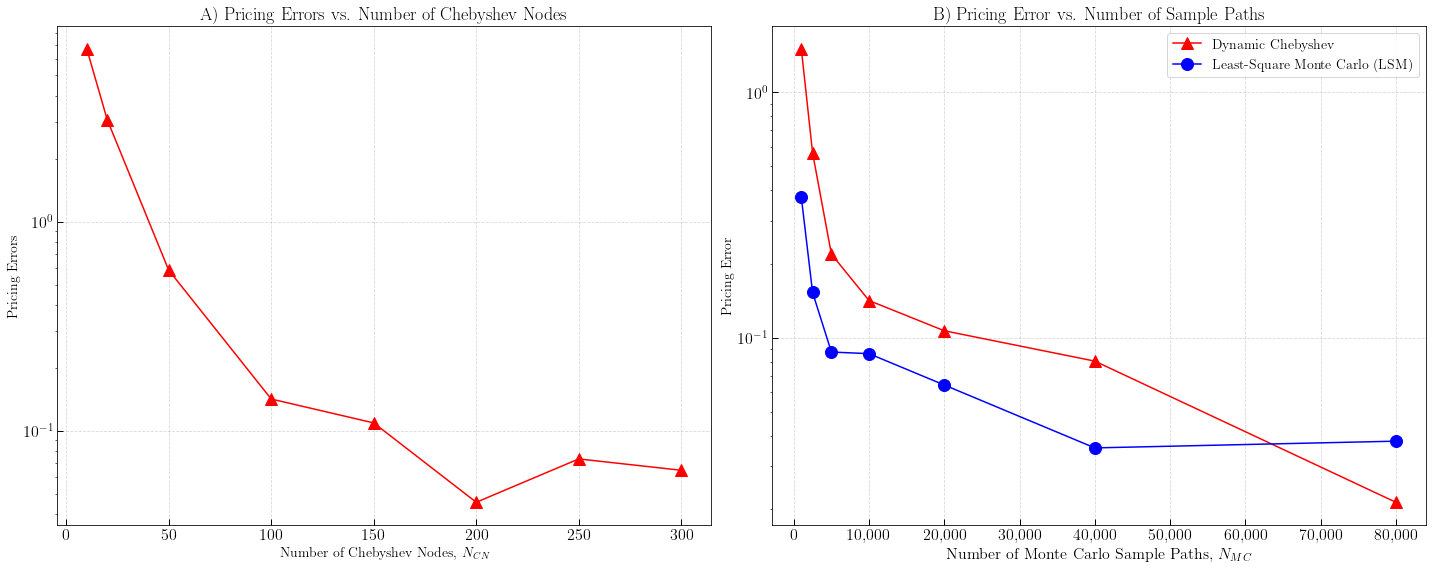

In [15]:
# Adjusting the style of the plots to include lines and use comma separators for thousands

# Subplot A with lines connecting markers
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(varying_params, log_errors, 'r^-', markersize=12, label='Log Errors')
plt.yscale('log')
plt.xlabel('Number of Chebyshev Nodes, $N_{CN}$', fontsize=14)  # Escaping the # symbol for LaTeX
plt.ylabel('Pricing Errors', fontsize=14)
plt.title('A) Pricing Errors vs. Number of Chebyshev Nodes', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', direction='in', length=6, width=1, colors='black', grid_alpha=0.5, labelsize=16)

# Subplot B with lines connecting markers
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(monte_carlo_paths, dynamic_chebyshev_errors, 'r^-', label='Dynamic Chebyshev', markersize=12)
plt.plot(monte_carlo_paths, lsm_errors, 'bo-', label='Least-Square Monte Carlo (LSM)', markersize=12)
plt.yscale('log')
plt.xlabel('Number of Monte Carlo Sample Paths, $N_{MC}$', fontsize=16)
plt.ylabel('Pricing Error', fontsize=14)
plt.title('B) Pricing Error vs. Number of Sample Paths', fontsize=18)
plt.legend(loc='upper right', fontsize=14, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', direction='in', length=6, width=1, colors='black', grid_alpha=0.5, labelsize=16)

# Adjust x-axis labels to include comma as a thousand separator
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()

# Check for directory and save the figure
if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")

plt.savefig("../Results/plots/Convergence.pdf", bbox_inches='tight')

# Show the plot
plt.show()